In [1]:
import dd
import numpy as np
import matplotlib.pyplot as plt
from getsig import getsig
from ddremoveELMData import *
import kk_abock
plt.style.use('helvet2')

In [2]:
class objview(object):
    def __init__(self, d):
        self.__dict__=d

In [3]:
def pedshtf(shotnr=30554, exper='guimas', edition=3, nr_diags=4):
    ped = dd.shotfile('PED', shotnr, experiment='guimas', edition=edition)
    t1 = ped('t1')
    t2 = ped('t2')
    nedata = ped('neData')
    mskz = nedata.data!=0.0
    rhos = nedata.area.data[0,mskz]
    dens = nedata.data[mskz]
    diagind = ped('DiagIndx')
    nedpts = ped('neDPts')
    indexesr = nedpts.data[nedpts.data!=0]
    tstart = ped('tstart')
    tstop = ped('tstop')
    neRshift = ped('neRshift')
    ped.close()
    
    #Check the intervals
    indi = np.zeros(nr_diags).astype(int)
    indf = np.zeros(nr_diags).astype(int)
    #Initialize arrays
    indf[0] = np.array(indexesr[0]-1).astype(int)

    for i in range(1,nr_diags):
        indi[i] = np.sum(indexesr[0:i]).astype(int)
        indf[i] = np.sum(indexesr[0:i+1]).astype(int)-1
        
    #Gets the average separatrix position
    fpg = getsig(shotnr, 'FPG', 'Raus')
    fpgmsk = ddremoveELMData(shotnr, fpg.time, preft=0.002, suft=0.004, elm_exper='guimas')
    fpgind = (fpg.time>=t1.data)&(fpg.time<=t2.data)&fpgmsk
    fpgavg = np.mean(fpg.data[fpgind])
    
    import kk_abock
    eq = kk_abock.kk()
    eq.Open(shotnr, diag='FPP')
    radius = eq.rhopol_to_Rz((np.float(t1.data)+np.float(t2.data))/2.0, rhos, 0.0)
    rad = radius['R']
    eq.Close()
    
    return objview({'t1':np.array(t1.data),
                    't2':np.array(t2.data),
                    'rhos':np.array(rhos),
                    'rad':np.array(rad),
                    'dens':np.array(dens),
                    'indi':np.array(indi),
                    'indf':np.array(indf),
                    'neRshift':np.array(neRshift),
                    'fpgavg':np.array(fpgavg)})

#### Read the data

In [4]:
p1 = pedshtf(shotnr=30554, exper='guimas', edition=7, nr_diags=4)
p2 = pedshtf(shotnr=30554, exper='guimas', edition=8, nr_diags=4)
p3 = pedshtf(shotnr=30554, exper='guimas', edition=9, nr_diags=4)
pall = [p1, p2, p3]

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:117: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)
/afs/ipp/aug/ads-diags/common/python/lib/dd.py:117: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)
/afs/ipp/aug/ads-diags/common/python/lib/dd_20180216.py:117: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)


#### Plots

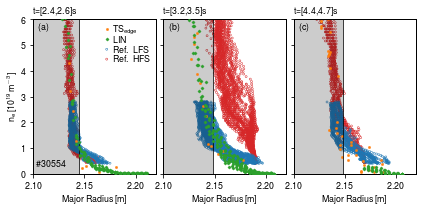

In [12]:
dotsize = 5
dotsizeref = 4
zorder = np.array([3,2,1,0])
labels = [r'$\mathrm{TS_{edge}}$', 'LIN', 'Ref. LFS', 'Ref. HFS']
framebox = [False, True, False]

cutsl = [2.135, 2.13, 2.13]
cutsh = [2.129, 2.14, 0.0]
textlabels= ['(a)','(b)','(c)']
fpgshift = [-0.003,0.0,0.0]

fig, ax = plt.subplots(figsize=(6,3),ncols=3,nrows=1,sharey=True)

for i in range(3):

    #TS edge
    ax[i].scatter(pall[i].rad[pall[i].indi[0]:pall[i].indf[0]], pall[i].dens[pall[i].indi[0]:pall[i].indf[0]]*1e-19,
                  s=dotsize, zorder=2, label=labels[0],facecolors="C1", marker='o')
    #LIN
    ax[i].scatter(pall[i].rad[pall[i].indi[1]:pall[i].indf[1]], pall[i].dens[pall[i].indi[1]:pall[i].indf[1]]*1e-19,
                  s=dotsize, zorder=3, label=labels[1],facecolors='C2', marker='D')
    #Clean up LFS ref
    lrad = pall[i].rad[pall[i].indi[2]:pall[i].indf[2]]
    ldens = pall[i].dens[pall[i].indi[2]:pall[i].indf[2]]
    lms = lrad>cutsl[i]
    ax[i].scatter(lrad[lms], ldens[lms]*1e-19, s=dotsizeref, zorder=1, label=labels[2], facecolors='none', edgecolors="C0", marker='o')
    #Clean up HFS ref
    hrad = pall[i].rad[pall[i].indi[3]:pall[i].indf[3]]
    hdens = pall[i].dens[pall[i].indi[3]:pall[i].indf[3]]
    hms = hrad>cutsh[i]
    ax[i].scatter(hrad[hms], hdens[hms]*1e-19, s=dotsizeref, zorder=0, label=labels[3],facecolors='none', edgecolors="C3", marker='o')

    #Separatrixes
    ax[i].axvline(pall[0].fpgavg+fpgshift[i], color='k', lw=0.7)
    ax[i].axvspan(2.1, pall[0].fpgavg+fpgshift[i], color='k', alpha=0.2)

    ax[i].set_xlabel(r'$\mathrm{Major\,Radius\,[m]}$')
    
    ax[i].set_ylim(0,6)
    ax[i].set_xlim(2.10,2.22)

    ax[i].set_title('t=[%0.1f,%0.1f]s'%(pall[i].t1,pall[i].t2), loc='left', fontsize=9)

    ax[i].set_xticks([2.10,2.15,2.20])
    ax[i].text(2.105,5.6,textlabels[i], color='k')

    #ax[i].legend(loc='upper right',borderpad=0.1,frameon=framebox[i],handletextpad=-0.3,labelspacing=0.1)

ax[0].legend(loc='upper right',borderpad=0.1,frameon=False,handletextpad=-0.3,labelspacing=0.1)
ax[0].set_ylabel(r'$\mathrm{n_e\,[10^{19}m^{-3}]}$')
ax[0].text(2.103, 0.3,'\#30554',color='k')
#
plt.tight_layout()
plt.subplots_adjust(wspace=0.06)
plt.savefig('Profiles/All_30554.png',dpi=300)
plt.show()